In [181]:
import glob
import pandas as pd
import numpy as np
import sys
import operator
import numpy as np
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices', 'f', 'datetime', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
pd.options.display.max_columns = None

In [132]:
# importing pluto sas area shapefile
poi_pluto = gpd.GeoDataFrame(gpd.read_file("PLUTO/area_of_interest3.shp"))
poi_pluto.head()

!mkdir -p data/
!wget -nc -O data/2016_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2016/2016_manhattan.xls
!wget -nc -O data/2015_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2015/2015_manhattan.xls
!wget -nc -O data/2014_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
!wget -nc -O data/2013_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
!wget -nc -O data/2012_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
!wget -nc -O data/2011_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
!wget -nc -O data/2010_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
!wget -nc -O data/2009_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
!wget -nc -O data/2008_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls

files = glob.glob("data/*.xls")
dfs = [pd.read_excel(f, skiprows=4) for f in files]

for df in dfs:
    df.columns = ["_".join(x.strip().split(" ")) for x in df.columns]

manhattan_sales = pd.concat(dfs)
manhattan_sales.head()
len(manhattan_sales.drop_duplicates())

OrderedDict([(u'Borough', 'str:2'), (u'Block', 'int:10'), (u'Lot', 'int:10'), (u'CD', 'int:10'), (u'CT2010', 'str:7'), (u'CB2010', 'str:5'), (u'SchoolDist', 'str:2'), (u'Council', 'int:10'), (u'ZipCode', 'int:10'), (u'FireComp', 'str:4'), (u'PolicePrct', 'int:10'), (u'HealthArea', 'int:10'), (u'SanitBoro', 'str:1'), (u'SanitDistr', 'str:2'), (u'SanitSub', 'str:2'), (u'Address', 'str:28'), (u'ZoneDist1', 'str:9'), (u'ZoneDist2', 'str:9'), (u'ZoneDist3', 'str:9'), (u'ZoneDist4', 'str:9'), (u'Overlay1', 'str:4'), (u'Overlay2', 'str:4'), (u'SPDist1', 'str:6'), (u'SPDist2', 'str:6'), (u'SPDist3', 'str:6'), (u'LtdHeight', 'str:5'), (u'SplitZone', 'str:1'), (u'BldgClass', 'str:2'), (u'LandUse', 'str:2'), (u'Easements', 'int:10'), (u'OwnerType', 'str:1'), (u'OwnerName', 'str:21'), (u'LotArea', 'int:10'), (u'BldgArea', 'int:10'), (u'ComArea', 'int:10'), (u'ResArea', 'int:10'), (u'OfficeArea', 'int:10'), (u'RetailArea', 'int:10'), (u'GarageArea', 'int:10'), (u'StrgeArea', 'int:10'), (u'FactryAre

83238

In [27]:
len(manhattan_sales.drop_duplicates(subset=['SALE_DATE', 'ADDRESS', 'SALE_PRICE']))

76309

TypeError: type object argument after * must be an iterable, not itertools.imap

In [133]:
merged = manhattan_sales.merge(poi_pluto, left_on=["BLOCK", "LOT"], right_on=["Block", "Lot"])
merged["SALE_MONTH"] = merged["SALE_DATE"].apply(lambda x: str(x.year) + "-" + str(x.month))
l = list(merged.columns)
l.remove("geometry")
merged = merged.drop_duplicates(subset=l)
merged = merged[merged["SALE_PRICE"] > 0]
merged["APT"] = merged["ADDRESS"].str.split(",").apply(lambda x: x[1].strip() if len(x) > 1 else "")
def gen_price_plot(min_price, max_price, title=None, ax=None, line_label=None, v=False):
    sales_means = merged[(merged["SALE_PRICE"] >= min_price) & (merged["SALE_PRICE"] <= max_price)]\
                    .groupby("SALE_MONTH")\
                    .median()["SALE_PRICE"]
    sales_means.index = sales_means.index.map(lambda x: pd.to_datetime(x))
    ax2 = sales_means.plot(figsize=(16, 9), ax=ax, label=line_label)
    if not ax:
        ax2.set_xlabel("Year - Month")
        ax2.set_ylabel("Price ($$$)")
    ax2.set_title("Prices over time" if not title else title)
    if v:
        ax2.axvline(datetime.datetime(2017, 1, 1), c='r', linestyle='--', label='SAS opening')
        ax2.legend()
    return ax2, l

In [138]:
merged = merged[merged["SALE_PRICE"] > 0]
len(merged)

7732

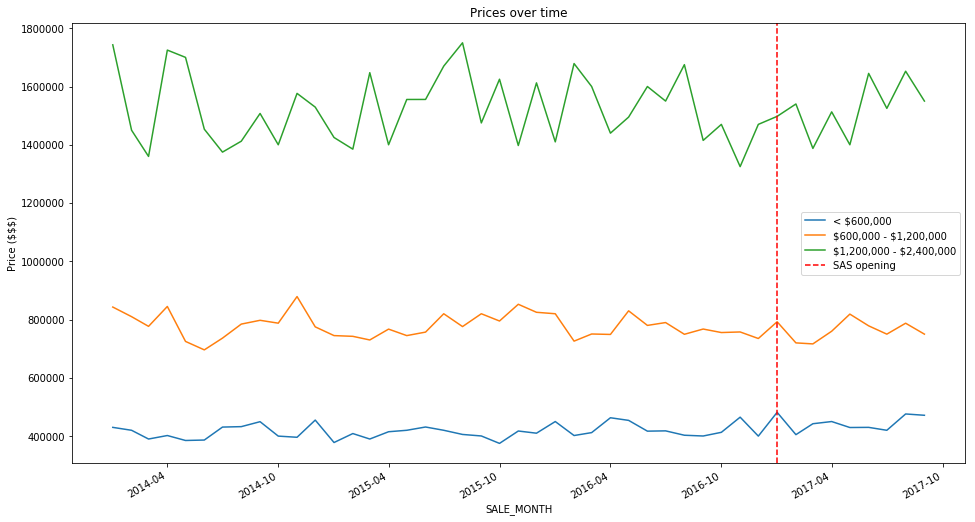

In [153]:
ax, l = gen_price_plot(100000, 600000, "Median sales price", line_label="< \$600,000")
ax, l = gen_price_plot(600000, 1200000, ax=ax, line_label="\$600,000 - \$1,200,000")
ax, l = gen_price_plot(1200000, 2400000, ax=ax, line_label="\$1,200,000 - $2,400,000", v=True)

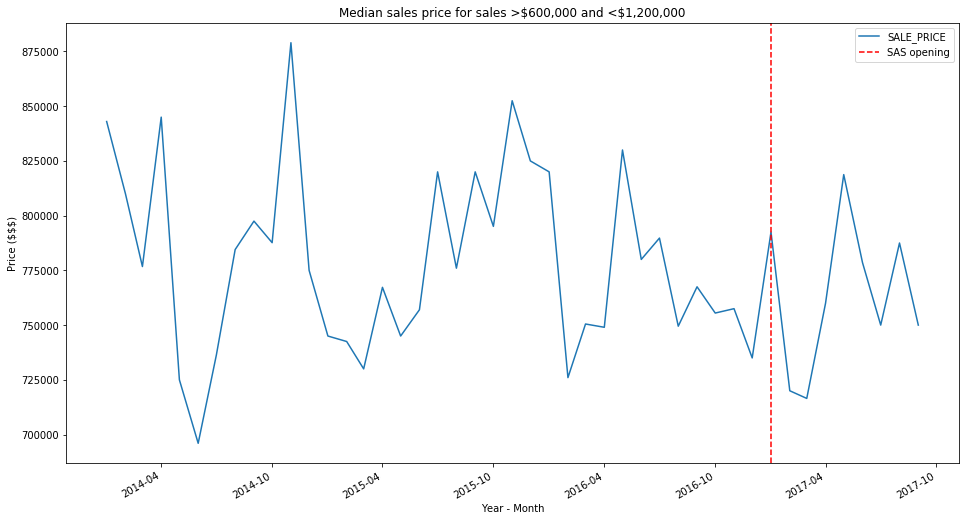

In [123]:
gen_price_plot(600000, 1200000, "Median sales price for sales >\$600,000 and <\$1,200,000")

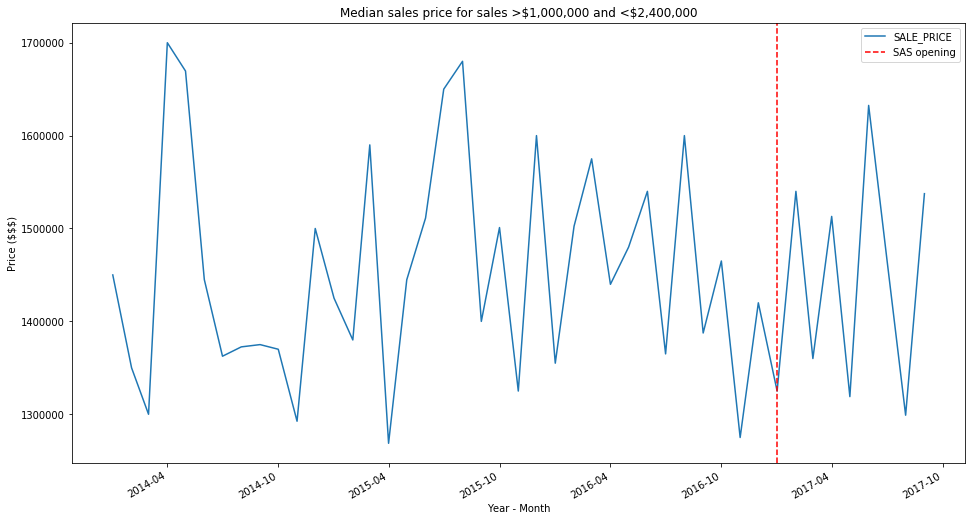

In [126]:
gen_price_plot(1000000, 2400000, "Median sales price for sales >\$1,000,000 and <\$2,400,000")

In [187]:
def gen_vol_plot(min_price, max_price, title=None, ax=None, line_label=None, v=False):
    sales_vols = merged[(merged["SALE_PRICE"] >= min_price) &\
                        (merged["SALE_PRICE"] <= max_price)]["SALE_MONTH"]\
                   .value_counts()
    sales_vols.index = sales_vols.index.map(lambda x: pd.to_datetime(x))
    ax2 = sales_vols.plot(figsize=(16, 9), ax=ax, label=line_label, linewidth=3)
    if not ax:
        ax2.set_xlabel("Year - Month")
        ax2.set_ylabel("Volume (# sales)")
    ax2.set_title("Volumes over time" if not title else title)
    if v:
        ax2.axvline(datetime.datetime(2017, 1, 1), c='r', linestyle='--', label='SAS opening')
        ax2.legend()
    return ax2, l

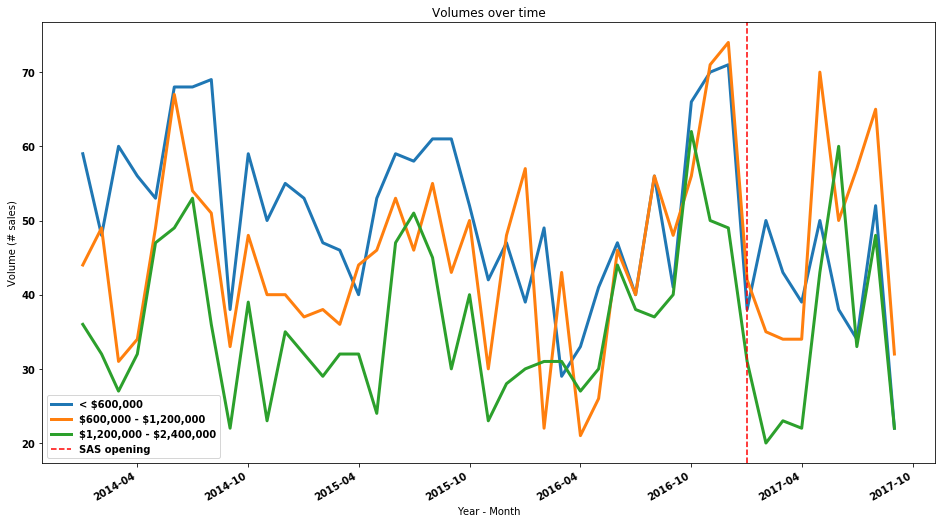

In [188]:
ax, l = gen_vol_plot(100000, 600000, "Median sales price", line_label="< \$600,000")
ax, l = gen_vol_plot(600000, 1200000, ax=ax, line_label="\$600,000 - \$1,200,000")
ax, l = gen_vol_plot(1200000, 2400000, ax=ax, line_label="\$1,200,000 - $2,400,000", v=True)

In [26]:
# Changing header for easy merging
sales = sales.rename(columns={'BOROUGHBLOCKLOT': 'BBL'})
sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BBL
0,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,376.0,24.0,,C0,264 EAST 7TH STREET,,...,0,3,"\t2,059","\t3,696",1900,1.0,C0,"\t7,738,700",12/22/16,137624.0
1,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,375.0,28.0,,C4,738 EAST 6TH STREET,,...,0,11,"\t1,750","\t6,500",1900,2.0,C4,"\t3,750,000",4/3/17,137528.0
2,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,385.0,36.0,,C7,27 AVENUE C,,...,1,25,"\t2,650","\t9,960",1910,2.0,C7,"\t5,235,000",7/11/17,138536.0
3,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392.0,5.0,,C2,151 AVENUE B,,...,0,5,"\t2,139","\t4,416",1900,2.0,C2,\t-,6/16/17,13925.0
4,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392.0,6.0,,C2,153 AVENUE B,,...,0,5,"\t1,633","\t6,440",1900,2.0,C2,"\t6,625,000",7/19/17,13926.0


In [28]:
# dropping nans and changing BBL to int for consistent formatting for merge
sales = sales[np.isfinite(sales['BBL'])]
sales.BBL = sales.BBL.astype(int)
len(sales)

17802

In [34]:
# force these to play nice
poi_pluto.BBL = sales.BBL

# merging
df = pd.merge(poi_pluto, sales, on='BBL')

len(df)

7055

In [39]:
sales["SALE DATE"].min()

'1/1/17'

___

### Finding time delta from sale to SAS opening 

In [11]:
# changing sale date to datetime
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
# creating new column for subtraction with date of opening
df['sas'] = ('1/1/17')
# change to datetime
df['sas'] = pd.to_datetime(df['sas'])

In [12]:
# new column with change in time to sas opening
df['time'] = (df['SALE DATE'] - df['sas']).astype('timedelta64')
df.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,sas,time
0,MN,1440,49,108,118,5000,02,5,10065,L016,...,3,"\t2,059","\t3,696",1900,1.0,C0,"\t7,738,700",2016-12-22,2017-01-01,-8.640000e+14
1,MN,1422,7501,108,118,3000,02,4,10065,L016,...,11,"\t1,750","\t6,500",1900,2.0,C4,"\t3,750,000",2017-04-03,2017-01-01,7.948800e+15
2,MN,1422,36,108,118,3000,02,4,10065,L016,...,25,"\t2,650","\t9,960",1910,2.0,C7,"\t5,235,000",2017-07-11,2017-01-01,1.650240e+16
3,MN,1422,2,108,118,3000,02,4,10065,L016,...,5,"\t2,139","\t4,416",1900,2.0,C2,\t-,2017-06-16,2017-01-01,1.434240e+16
4,MN,1424,43,108,126,4000,02,4,10021,L016,...,5,"\t1,633","\t6,440",1900,2.0,C2,"\t6,625,000",2017-07-19,2017-01-01,1.719360e+16


In [13]:
# wtf, is this format correct? 
df.time.describe()

count    7.055000e+03
mean     7.434686e+15
std      8.808533e+15
min     -7.948800e+15
25%     -1.728000e+14
50%      7.430400e+15
75%      1.529280e+16
max      2.332800e+16
Name: time, dtype: float64

# To do
- plot average sales prices and time to sas opening
- build regression model with inputs predicting price: time to sas opening, distance to subway, (other housing characteristics)
- write the damn thing up


In [203]:
old_format = pd.options.display.float_format
pd.options.display.float_format = '${:,.2f}'.format
l0 = merged[merged["SALE_PRICE"] < 2400000][["SALE_PRICE"]].describe()
l0.loc["count"] = l0.loc["count"].astype(str)
l0.columns = ["Sale Price for all (max \$2.4m)"]
l0

,Sale Price for all (max \$2.4m)
count,[4057.0]
mean,"$669,659.58"
std,"$504,425.55"
min,$0.00
25%,"$355,000.00"
50%,"$570,000.00"
75%,"$866,500.00"
max,"$2,387,000.00"


In [204]:
min_price = 100000
max_price = 600000
l1 = merged[(merged["SALE_PRICE"] >= min_price) &\
                        (merged["SALE_PRICE"] <= max_price)][["SALE_PRICE"]].describe()
l1.loc["count"] = l1.loc["count"].astype(str)
l1.columns = ["Sale Price for <\$600k"]
l1

,Sale Price for <\$600k
count,[1612.0]
mean,"$422,994.30"
std,"$100,880.97"
min,"$100,335.00"
25%,"$345,000.00"
50%,"$420,000.00"
75%,"$504,900.00"
max,"$600,000.00"


In [205]:
min_price = 600000
max_price = 1200000
l2 = merged[(merged["SALE_PRICE"] >= min_price) &\
                        (merged["SALE_PRICE"] <= max_price)][["SALE_PRICE"]].describe()
l2.loc["count"] = l2.loc["count"].astype(str)
l2.columns = ["Sale Price for >\$600k and <\$1.2m"]
l2

,Sale Price for >\$600k and <\$1.2m
count,[1278.0]
mean,"$800,137.43"
std,"$154,763.86"
min,"$600,000.00"
25%,"$675,000.00"
50%,"$768,750.00"
75%,"$885,000.00"
max,"$1,200,000.00"


In [207]:
min_price = 1200000
max_price = 2400000
l3 = merged[(merged["SALE_PRICE"] >= min_price) &\
                        (merged["SALE_PRICE"] <= max_price)][["SALE_PRICE"]].describe()
l3.loc["count"] = l3.loc["count"].astype(str)
l3.columns = ["Sale Price for >\$1.2m and <\$2.4m"]
l3

l0.join(l1).join(l2).join(l3)

,Sale Price for all (max \$2.4m),Sale Price for <\$600k,Sale Price for >\$600k and <\$1.2m,Sale Price for >\$1.2m and <\$2.4m
count,[4057.0],[1612.0],[1278.0],[667.0]
mean,"$669,659.58","$422,994.30","$800,137.43","$1,595,999.85"
std,"$504,425.55","$100,880.97","$154,763.86","$314,851.37"
min,$0.00,"$100,335.00","$600,000.00","$1,200,000.00"
25%,"$355,000.00","$345,000.00","$675,000.00","$1,333,500.00"
50%,"$570,000.00","$420,000.00","$768,750.00","$1,520,000.00"
75%,"$866,500.00","$504,900.00","$885,000.00","$1,800,000.00"
max,"$2,387,000.00","$600,000.00","$1,200,000.00","$2,400,000.00"


In [209]:
merged["SALE_YEAR"] = merged["SALE_DATE"].apply(lambda x: x.year)

In [221]:
merged[(merged["SALE_PRICE"] > 100000) & (merged["SALE_PRICE"] < 2400000)].groupby("SALE_YEAR")["SALE_PRICE"].describe().swapaxes(1, 0)

SALE_YEAR,2014,2015,2016,2017
count,$964.00,$952.00,$946.00,$640.00
mean,"$738,260.37","$777,023.75","$781,589.32","$819,970.68"
std,"$456,830.14","$481,249.21","$447,665.91","$455,025.37"
min,"$113,669.00","$101,825.00","$100,335.00","$195,000.00"
25%,"$407,500.00","$419,750.00","$440,500.00","$484,162.50"
50%,"$595,000.00","$620,000.00","$649,000.00","$686,000.00"
75%,"$899,000.00","$950,000.00","$936,250.00","$971,250.00"
max,"$2,375,000.00","$2,387,000.00","$2,375,000.00","$2,381,250.00"


In [232]:
def sale_group(x):
    if x >= 100000 and x <= 600000:
        return "< \$600,000"
    if x > 600000 and x <= 1200000:
        return "\$600,000 - \$1,200,000"
    if x > 1200000 and x <= 2400000:
        return "\$1,200,000 - \$2,400,000"
merged["SALE_GROUP"] = merged["SALE_PRICE"].apply(sale_group)
q = merged[(merged["SALE_PRICE"] > 100000) & (merged["SALE_PRICE"] < 2400000)].groupby(["SALE_GROUP", "SALE_YEAR"])["SALE_PRICE"].describe()

In [233]:
q.index.names = ["Price Range", "Year"]

In [241]:
q["count"] = q["count"].apply(str)
q.swapaxes(1, 0)[["< \$600,000","\$600,000 - \$1,200,000", "\$1,200,000 - \$2,400,000" ]]

Price Range < \$600,000                                      \
Year               2014        2015        2016        2017   
count             494.0       452.0       417.0       249.0   
mean        $411,311.66 $418,532.77 $427,998.32 $445,890.52   
std         $105,409.85  $99,474.06 $101,476.89  $88,750.08   
min         $113,669.00 $101,825.00 $100,335.00 $195,000.00   
25%         $325,000.00 $340,000.00 $350,000.00 $380,000.00   
50%         $410,000.00 $410,000.00 $420,000.00 $445,000.00   
75%         $491,500.00 $499,000.00 $515,000.00 $515,000.00   
max         $600,000.00 $600,000.00 $600,000.00 $600,000.00   

Price Range \$600,000 - \$1,200,000                                            \
Year                           2014          2015          2016          2017   
count                         314.0         320.0         347.0         266.0   
mean                    $820,313.36   $802,105.52   $796,355.13   $802,211.44   
std                     $166,533.45   $152,066.82   $146,626.71   $146,836.40   
min                     $605,000.00   $602,714.00   $601,500.00   $603,000.00   
25%                     $680,000.00   $673,750.00   $680,000.00   $680,000.00   
50%                     $784,500.00   $769,750.00   $772,500.00   $771,000.00   
75%                     $925,000.00   $898,500.00   $874,375.00   $884,250.00   
max                   $1,200,000.00 $1,200,000.00 $1,200,000.00 $1,200,000.00   

Price Range \$1,200,000 - \$2,400,000                              \
Year                             2014          2015          2016   
count                           156.0         180.0         182.0   
mean                    $1,608,440.03 $1,632,644.65 $1,563,587.71   
std                       $298,037.89   $320,150.90   $279,613.78   
min                     $1,210,000.00 $1,205,917.00 $1,212,500.00   
25%                     $1,350,000.00 $1,363,750.00 $1,341,250.00   
50%                     $1,540,000.00 $1,580,500.00 $1,477,500.00   
75%                     $1,802,500.00 $1,875,000.00 $1,740,000.00   
max                     $2,375,000.00 $2,387,000.00 $2,375,000.00   

Price Range                
Year                 2017  
count               125.0  
mean        $1,602,930.05  
std           $324,789.91  
min         $1,205,000.00  
25%         $1,300,000.00  
50%         $1,537,557.00  
75%         $1,770,000.00  
max         $2,381,250.00

In [242]:
merged.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,FID_1,distance_m,nearest_st,geometry,SALE_MONTH,SALE_YEAR,SALE_GROUP
0,1,MANHATTAN-UNKNOWN,01 ONE FAMILY DWELLINGS,,1528,127,,A4,248 EAST 83RD STREET,,...,0,$143.92,$942.48,915,$264.36,1,"POLYGON ((997105.0698000044 222004.2342000008,...",2016-12,2016,None
1,1,UPPER EAST SIDE (79-96),01 ONE FAMILY DWELLINGS,1,1528,127,,A4,248 EAST 83RD STREET,,...,0,$143.92,$942.48,915,$264.36,1,"POLYGON ((997105.0698000044 222004.2342000008,...",2016-12,2016,None
2,1,MANHATTAN-UNKNOWN,02 TWO FAMILY DWELLINGS,,1528,128,,B9,246 EAST 83RD STREET,,...,0,$142.36,$899.72,1036,$265.13,1,"POLYGON ((997090.0150000006 222012.5840000063,...",2016-12,2016,None
3,1,UPPER EAST SIDE (79-96),02 TWO FAMILY DWELLINGS,1,1528,128,,B9,246 EAST 83RD STREET,,...,0,$142.36,$899.72,1036,$265.13,1,"POLYGON ((997090.0150000006 222012.5840000063,...",2016-12,2016,None
4,1,MANHATTAN-UNKNOWN,14 RENTALS - 4-10 UNIT,,1528,25,,S3,1591 SECOND AVENUE,,...,0,$262.40,"$2,636.14",993,$282.96,1,"POLYGON ((997129.914199993 221899.0929999948, ...",2016-12,2016,None


In [244]:
list(merged.columns)

[u'BOROUGH',
 u'NEIGHBORHOOD',
 u'BUILDING_CLASS_CATEGORY',
 u'TAX_CLASS_AT_PRESENT',
 u'BLOCK',
 u'LOT',
 u'EASE-MENT',
 u'BUILDING_CLASS_AT_PRESENT',
 u'ADDRESS',
 u'APARTMENT_NUMBER',
 u'ZIP_CODE',
 u'RESIDENTIAL_UNITS',
 u'COMMERCIAL_UNITS',
 u'TOTAL_UNITS',
 u'LAND_SQUARE_FEET',
 u'GROSS_SQUARE_FEET',
 u'YEAR_BUILT',
 u'TAX_CLASS_AT_TIME_OF_SALE',
 u'BUILDING_CLASS_AT_TIME_OF_SALE',
 u'SALE_PRICE',
 u'SALE_DATE',
 u'Borough',
 u'Block',
 u'Lot',
 u'CD',
 u'CT2010',
 u'CB2010',
 u'SchoolDist',
 u'Council',
 u'ZipCode',
 u'FireComp',
 u'PolicePrct',
 u'HealthArea',
 u'SanitBoro',
 u'SanitDistr',
 u'SanitSub',
 u'Address',
 u'ZoneDist1',
 u'ZoneDist2',
 u'ZoneDist3',
 u'ZoneDist4',
 u'Overlay1',
 u'Overlay2',
 u'SPDist1',
 u'SPDist2',
 u'SPDist3',
 u'LtdHeight',
 u'SplitZone',
 u'BldgClass',
 u'LandUse',
 u'Easements',
 u'OwnerType',
 u'OwnerName',
 u'LotArea',
 u'BldgArea',
 u'ComArea',
 u'ResArea',
 u'OfficeArea',
 u'RetailArea',
 u'GarageArea',
 u'StrgeArea',
 u'FactryArea',
 u'Ot

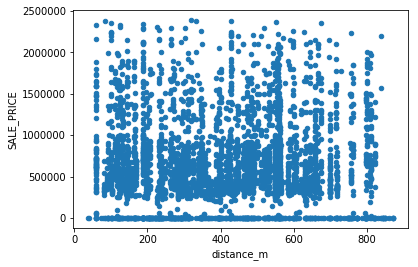

In [247]:
merged[merged["SALE_PRICE"] < 2400000].plot("distance_m", "SALE_PRICE", kind="scatter")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3667126490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f366509bc50>]], dtype=object)

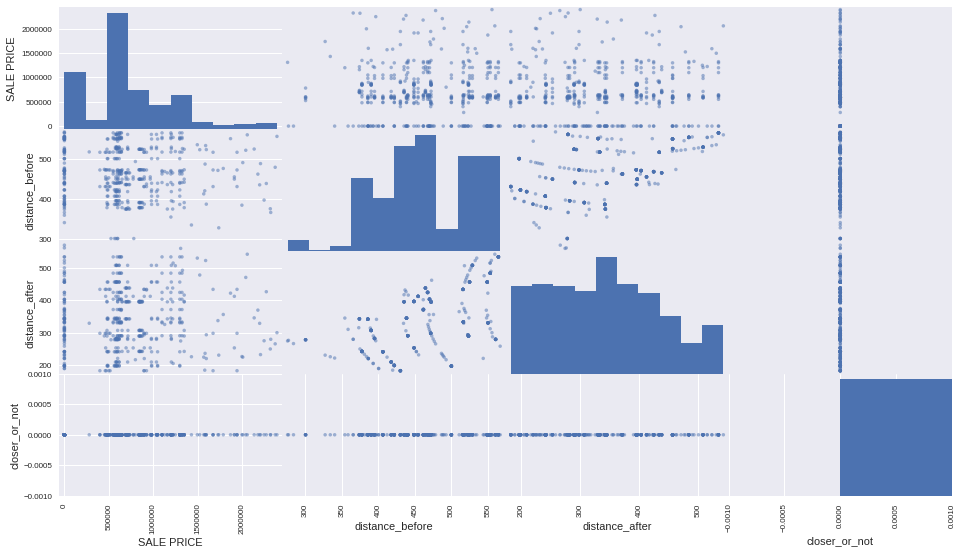

In [271]:
sales_csv = pd.read_csv("pluto_sales.csv")
sales_csv["SALE PRICE"] = sales_csv["SALE PRICE"].apply(lambda x: float("".join(x.split(",")).strip()) if '-' not in x else 0.0)

import seaborn as sns
f = sales_csv[(sales_csv["SALE PRICE"] < 2400000)&(sales_csv["closer_or_not"] == 0)][["SALE PRICE", "distance_before", "distance_after", "closer_or_not"]]
from pandas.plotting import scatter_matrix
scatter_matrix(f, figsize=(16, 9))

In [275]:
pd.options.display.max_columns = None
merged[(merged["SALE_PRICE"] > 0) & (merged["SALE_PRICE"] < 2400000)].head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,FID_1,distance_m,nearest_st,geometry,SALE_MONTH,SALE_YEAR,SALE_GROUP
47,1,UPPER EAST SIDE (59-79),07 RENTALS - WALKUP APARTMENTS,2,1490,1,,C7,1472 YORK AVENUE,,10075,184,8,192,22681,98622,1911,2,C7,1500000,2017-05-24,MN,1490,1,108,132,5000,02,5,10075,E022,19,4300,1,08,3B,1472 YORK AVENUE,R10A,,,,C1-5,,,,,,N,C7,04,0,P,78/79 YORK ASSOCIATES,22681,98622,8000,90622,0,8000,0,0,0,0,2,4,$6.00,184,192,$204.33,$111.00,$204.33,$96.00,,0,N,5,5,"$2,331,000.00","$11,945,700.00",$0.00,"$6,767,559.00",1911,1996,2003,,"CITY AND SUBURBAN HOMES COMPANY, AV",$4.35,$10.00,$0.00,$10.00,1,"$1,014,900,001.00",0,0132,997993,220141,9a,,108S020,10512,,$0.00,,1,16V2,0,$673.54,"$26,192.54",210,$712.89,0,"POLYGON ((998098.8486000001 220205.409799993, ...",2017-5,2017,"\$1,200,000 - \$2,400,000"
98,1,UPPER EAST SIDE (59-79),09 COOPS - WALKUP APARTMENTS,2,1431,1,,C6,1337 THIRD AVENUE,,10075,.,.,.,.,.,1910,2,C6,100335,2016-12-05,MN,1431,1,108,134,2000,02,4,10075,E044,19,4200,1,08,3A,1329 3 AVENUE,C1-9,,,,,,,,,,N,C6,02,0,P,1329-37 THIRD AVENUE,7867,23000,7420,15580,0,7420,0,0,0,0,2,5,$4.00,30,36,$102.17,$77.00,$60.00,$56.00,,2,N,3,2,"$405,000.00","$3,319,200.00",$0.00,$0.00,1910,1983,1997,,,$2.92,$10.00,$2.00,$10.00,1,"$1,014,310,001.00",0,0134,995799,220688,8c,,108S013,10510,,$0.00,,1,16V2,0,$365.19,"$8,179.05",1022,$400.32,0,"POLYGON ((995858.2740000039 220715.054399997, ...",2016-12,2016,"< \$600,000"
99,1,UPPER EAST SIDE (59-79),09 COOPS - WALKUP APARTMENTS,2,1431,1,,C6,1337 THIRD AVENUE,,10075,0,0,0,0,0,1910,2,C6,100335,2016-12-05,MN,1431,1,108,134,2000,02,4,10075,E044,19,4200,1,08,3A,1329 3 AVENUE,C1-9,,,,,,,,,,N,C6,02,0,P,1329-37 THIRD AVENUE,7867,23000,7420,15580,0,7420,0,0,0,0,2,5,$4.00,30,36,$102.17,$77.00,$60.00,$56.00,,2,N,3,2,"$405,000.00","$3,319,200.00",$0.00,$0.00,1910,1983,1997,,,$2.92,$10.00,$2.00,$10.00,1,"$1,014,310,001.00",0,0134,995799,220688,8c,,108S013,10510,,$0.00,,1,16V2,0,$365.19,"$8,179.05",1022,$400.32,0,"POLYGON ((995858.2740000039 220715.054399997, ...",2016-12,2016,"< \$600,000"
100,1,UPPER EAST SIDE (59-79),09 COOPS - WALKUP APARTMENTS,2,1432,36,,C6,"236 EAST 78 STREET, 4D",,10075,.,.,.,.,.,1910,2,C6,490000,2017-05-05,MN,1432,36,108,134,1000,02,4,10075,E044,19,4200,1,08,3A,236 EAST 78 STREET,R8B,,,,,,,,,,N,C6,02,0,,236 E 78TH STREET OWN,2554,11334,950,10384,0,950,0,0,0,0,2,1,$6.00,22,24,$25.00,$102.17,$25.00,$85.00,,3,N,5,2,"$272,250.00","$1,173,600.00","$4,720.00","$4,720.00",1910,1986,0,,,$4.44,$4.00,$0.00,$4.00,1,"$1,014,320,036.00",0,0134,996223,220875,8c,,108S013,10510,,$0.00,,1,16V2,0,$261.14,"$2,678.47",956,$476.58,0,"POLYGON ((996259.7153999954 220915.3077999949,...",2017-5,2017,"< \$600,000"
101,1,UPPER EAST SIDE (59-79),09 COOPS - WALKUP APARTMENTS,2,1432,36,,C6,"236 EAST 78TH STREET, 3A",,10075,0,0,0,0,0,1910,2,C6,325000,2015-10-26,MN,1432,36,108,134,1000,02,4,10075,E044,19,4200,1,08,3A,236 EAST 78 STREET,R8B,,,,,,,,,,N,C6,02,0,,236 

In [143]:
merged["APT"] = merged["ADDRESS"].str.split(",").apply(lambda x: x[1].strip() if len(x) > 1 else "")

In [58]:
merged.drop_duplicates(subset=)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,FID_1,distance_m,nearest_st,geometry,SALE_MONTH,APT
0,1,MANHATTAN-UNKNOWN,01 ONE FAMILY DWELLINGS,,1528,127,,A4,248 EAST 83RD STREET,,10028,1,0,1,851,3200,1901,1,A4,0,2016-12-01,MN,1528,127,108,138,4001,02,5,10028,E022,19,3700,1,08,4B,248 EAST 83 STREET,C1-9,,,,,,TA,,,,N,A4,01,0,,248 EAST 83 STREET LL,851,3200,0,2400,0,0,0,0,0,0,2,1,3.0,1,1,16.67,51.08,16.67,50.0,,3,N,5,1,59950.0,139220.0,0.0,0.0,1901,2006,0,,,3.76,10.0,2.0,10.0,1,1.015280e+09,0,0138,997084,221984,9a,,108S017,10514,,0.0,,1,16V2,0,143.920142,942.483619,915,264.355728,1,"POLYGON ((997105.0698000044 222004.2342000008,...",2016-12,
1,1,UPPER EAST SIDE (79-96),01 ONE FAMILY DWELLINGS,1,1528,127,,A4,248 EAST 83RD STREET,,10028,1,0,1,851,3200,1901,1,A4,0,2016-12-01,MN,1528,127,108,138,4001,02,5,10028,E022,19,3700,1,08,4B,248 EAST 83 STREET,C1-9,,,,,,TA,,,,N,A4,01,0,,248 EAST 83 STREET LL,851,3200,0,2400,0,0,0,0,0,0,2,1,3.0,1,1,16.67,51.08,16.67,50.0,,3,N,5,1,59950.0,139220.0,0.0,0.0,1901,2006,0,,,3.76,10.0,2.0,10.0,1,1.015280e+09,0,0138,997084,221984,9a,,108S017,10514,,0.0,,1,16V2,0,143.920142,942.483619,915,264.355728,1,"POLYGON ((997105.0698000044 222004.2342000008,...",2016-12,
2,1,MANHATTAN-UNKNOWN,02 TWO FAMILY DWELLINGS,,1528,128,,B9,246 EAST 83RD STREET,,10028,2,0,2,851,1998,1901,1,B9,0,2016-12-01,MN,1528,128,108,138,4001,02,5,10028,E022,19,3700,1,08,4B,246 EAST 83 STREET,C1-9,R8B,,,,,TA,,,,Y,B9,01,0,,246 EAST 83 STREET LL,851,1998,0,1998,0,0,0,0,0,0,2,1,3.0,2,2,16.67,51.08,16.67,40.0,,3,N,5,2,52361.0,124723.0,0.0,0.0,1901,0,0,,,2.35,10.0,2.0,10.0,1,1.015280e+09,0,0138,997069,221992,9a,,108S017,10514,,0.0,,1,16V2,0,142.359091,899.718961,1036,265.125436,1,"POLYGON ((997090.0150000006 222012.5840000063,...",2016-12,
3,1,UPPER EAST SIDE (79-96),02 TWO FAMILY DWELLINGS,1,1528,128,,B9,246 EAST 83RD STREET,,10028,2,0,2,851,2560,1901,1,B9,0,2016-12-01,MN,1528,128,108,138,4001,02,5,10028,E022,19,3700,1,08,4B,246 EAST 83 STREET,C1-9,R8B,,,,,TA,,,,Y,B9,01,0,,246 EAST 83 STREET LL,851,1998,0,1998,0,0,0,0,0,0,2,1,3.0,2,2,16.67,51.08,16.67,40.0,,3,N,5,2,52361.0,124723.0,0.0,0.0,1901,0,0,,,2.35,10.0,2.0,10.0,1,1.015280e+09,0,0138,997069,221992,9a,,108S017,10514,,0.0,,1,16V2,0,142.359091,899.718961,1036,265.125436,1,"POLYGON ((997090.0150000006 222012.5840000063,...",2016-12,
4,1,MANHATTAN-UNKNOWN,14 RENTALS - 4-10 UNIT,,1528,25,,S3,1591 SECOND AVENUE,,10028,3,1,4,2596,10400,1920,2,S3,0,2016-12-01,MN,1528,25,108,138,4001,02,5,10028,E022,19,3700,1,08,4B,1591 2 AVENUE,C1-9,R8B,,,,,TA,,,,Y,S3,04,0,,1591 SECOND AVENUE LL,2596,10400,5000,5400,0,5000,0,0,0,0,2,1,4.0,3,4,25.54,101.67,26.00,94.0,E,3,N,5,5,876222.0,1102248.0,0.0,0.0,1920,1997,0,,,4.01,10.0,2.0,10.0,1,1.015280e+09,0,0138,997077,221914,9a,,108S017,10514,,0.0,,1,16V2,0,262.401175,2636.140786,993,282.962096,1,"POLYGON ((997129.914199993 221899.0929999948, ...",2016-12,


In [144]:
count = 0
from datetime import datetime
cutoff = datetime(2017, 1, 1)
indices = []
for ix, group in merged.groupby(["Address", "APT"]):
    if ix[1] and group["SALE_DATE"].min() < cutoff and group["SALE_DATE"].max() >= cutoff:
        #print ix
        indices.append(group.index)
        #print "====="
        count += 1

In [145]:
count

98

In [146]:
i = indices[0]
for index in indices[1:]:
    i = i.append(index)

In [147]:
good_ones = merged.loc[i]

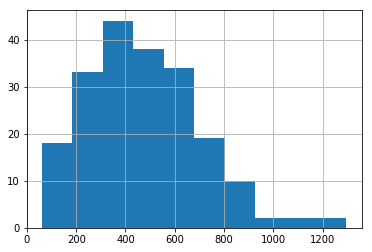

In [149]:
good_ones.distance.hist()

In [151]:
g = good_ones[(good_ones["SALE_PRICE"] < 1000000)].reset_index()
g["treatment"] = (g["distance"] < 400).astype(np.int)
g["after"] = (g["SALE_DATE"] >= cutoff).astyp

587440.34615384613

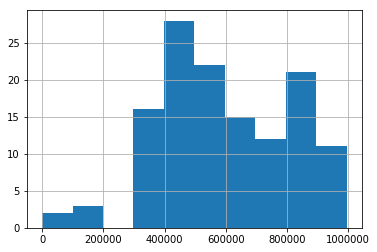

In [153]:
g["SALE_PRICE"].hist()
g["SALE_PRICE"].mean()

In [163]:
y11 = g[(g["treatment"] == 1) & (g["after"] == 1)]["SALE_PRICE"].mean()
y12 = g[(g["treatment"] == 1) & (g["after"] == 0)]["SALE_PRICE"].mean()


y21 = g[(g["treatment"] == 0) & (g["after"] == 1)]["SALE_PRICE"].mean()
y22 = g[(g["treatment"] == 0) & (g["after"] == 0)]["SALE_PRICE"].mean()
(y11 - y21) - (y12 - y22)

21649.346254659933

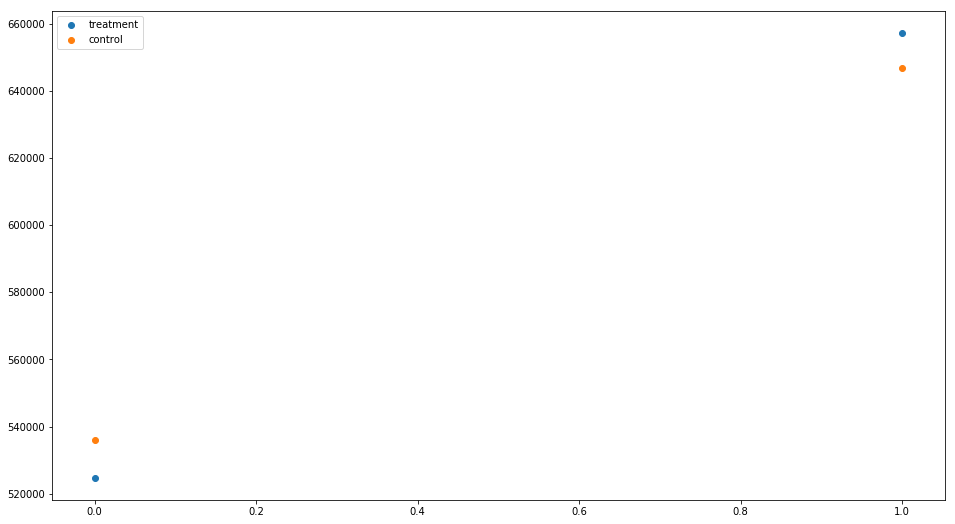

In [169]:
plt.figure(figsize=(16, 9))
plt.scatter([1, 0], [y11, y12], label="treatment")
plt.scatter([1, 0], [y21, y22], label="control")
plt.legend()

In [179]:
d

{'result': {'list': {'one_more_annoying_thing': ['a', 'b', 'c']}}}

In [122]:
len(g)

115

In [ ]:
r